<a href="https://colab.research.google.com/github/AraiKensuke/LOST/blob/master/Notebooks/AR2_priors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***The (implied) prior distribution when we sample from the likelihood of the AR coefficients, ie the prior is uniform over the coefficients***

In [ ]:
import sys
import importlib

if importlib.util.find_spec("LOST") is None:
  %cd /content
  !git clone https://github.com/AraiKensuke/LOST.git
  %cd /content/LOST

!python setup.py build_ext --inplace

sys.path.insert(1, "/content/LOST")    #  add these to searchpath for python modules
sys.path.insert(1, "/content/pyPG")    #  add these to searchpath for python modules

#from google.colab import files
#uploaded = files.upload()

/content
Cloning into 'LOST'...
remote: Enumerating objects: 452, done.
remote: Counting objects: 100% (452/452), done.
remote: Compressing objects: 100% (337/337), done.
remote: Total 593 (delta 228), reused 296 (delta 111), pack-reused 141
Receiving objects: 100% (593/593), 43.45 MiB | 24.80 MiB/s, done.
Resolving deltas: 100% (299/299), done.
/content/LOST
running build_ext
cythoning kfARlibMPmv_ram2.pyx to kfARlibMPmv_ram2.c
/usr/local/lib/python3.7/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/LOST/kfARlibMPmv_ram2.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'kfARlibMPmv_ram2' extension
creating build
creating build/temp.linux-x86_64-3.7
/usr/bin/gcc -Wno-unused-result -Wsign-compare -DNDEBUG -g -fwrapv -O2 -Wall -g -fdebug-prefix-map=/build/python3.7-a56wZI/python3.7-3.7.10=. -fstack-protector-strong -Wformat -Werror=format-securit

**AR(2) components have a frequency and modulus, the higher modulus results in more regular oscillations.**  We can sample AR(2) processes, but we need to parameterize the process, and sample the process by sampling the parameter space.  We can either parameterize through AR(2) coefficients that lead to a stationary, oscillatory AR(2) process, or parameterize using modulus and frequency.  First, we draw frequency and modulus uniformly, and see the corresponding AR(2) coefficients $F_1, F_2$ where $x_t = F_1 x_{t-1} + F_2 x_{t-2} + N(0, \sigma^2)$ and how they're distributed.

If we sample frequencies and modulus uniformly, these don't correspond to a uniform sampling in the coefficent space.  Similarly, if
we sample the coefficient $F_1$, $F_2$, this will lead to a non-uniform sampling of AR(2) processes in the space of frequency and modulus.

First, we sample frequencies and modulus uniformly, and plot out the resulting coefficients, red dots.  Then we sample the modulus with frequency set to 0, black dots.  

Text(0, 0.5, '$F_2$')

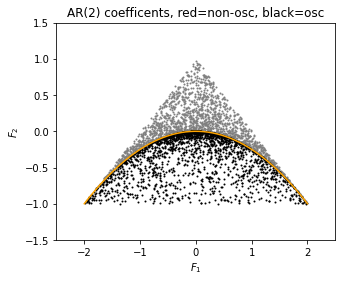

In [15]:
#  eigenvalue of AR
import LOST.ARlib as _arl
from LOST.ARcfSmplFuncs import ampAngRep, buildLims, FfromLims, dcmpcff, initF
import numpy as _N
import matplotlib.pyplot as _plt

#  the actual eigenvalues need | eigenvalue | < 1.  (1 / ev) > 1

k    = 2
N    = 2000
ra   = 0
rb   = 1

#########  imaginary roots
amps  = _N.random.rand(N) * (rb - ra) + ra
phs  = _N.random.rand(N) * _N.pi      #  phs from 0 -> pi   (well, 4pi/N, but large N->0)
Fsi  = _N.empty((N, 2))

for n in range(N):
    ph = phs[n]
    r1 = amps[n] * (_N.cos(ph) + 1j * _N.sin(ph))
    r2 = amps[n] * (_N.cos(ph) - 1j * _N.sin(ph))

    A = _N.array([[r1, 1], [r2, 1]])
    B = _N.array([[r1*r1], [r2*r2]])

    F1, F2 = _N.linalg.solve(A, B)
    F      = _N.array([F1, F2]).real
    Fsi[n, 0] = F[0]
    Fsi[n, 1] = F[1]

    # bBdd, iBdd, rts = _arl.cmplxRoots(F)
    # if not bBdd:
    #     print "Woops"


##########  real roots
amps = _N.random.rand(N, k) * (rb - ra) + ra
Fsr  = _N.empty((N, 2))

###  
for n in range(N):
    r1 = -1 + amps[n, 0] * 2
    r2 = -1 + amps[n, 1] * 2

    A = _N.array([[r1, 1], [r2, 1]])
    B = _N.array([[r1*r1], [r2*r2]])

    F1, F2 = _N.linalg.solve(A, B)
    F      = _N.array([F1, F2])
    Fsr[n, 0] = F[0]
    Fsr[n, 1] = F[1]

#    bBdd, iBdd, rts = _arl.cmplxRoots(F)
#    if not bBdd:
#        print "Woops"


x = _N.linspace(-2, 2, 201)
y = 0.25*(4 - x**2) - 1
    
#  rts == (1./(r1*r1.conjugate())), (1./(r1*r1.conjugate()))
fig = _plt.figure(figsize=(5, 4))
fig.add_subplot(1, 1, 1)
_plt.title("AR(2) coefficents, red=non-osc, black=osc")
_plt.scatter(Fsr[:, 0], Fsr[:, 1], marker=".", s=4, color="grey")
_plt.grid()
_plt.xlim(-2.5, 2.5)
_plt.ylim(-1.5, 1.5)
#fig.add_subplot(1, 2, 2)
_plt.scatter(Fsi[:, 0], Fsi[:, 1], marker=".", s=4, color="black")
_plt.plot(x, y, color="orange")
_plt.grid()
_plt.xlim(-2.5, 2.5)
_plt.ylim(-1.5, 1.5)
_plt.xlabel(r"$F_1$")
_plt.ylabel(r"$F_2$")




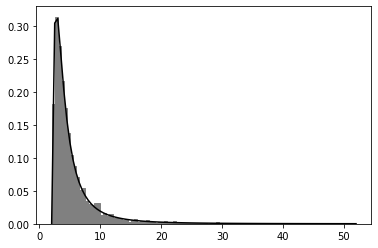

In [14]:
#  Sample oscillatory AR(2) coefficients

#  First sample uniform [-2, 2] x [-2, 2]
#  Reject if c2 < 0.25*(4-c1**2)-1 or c2 > c1+1 if c1 < 0 
#   or c2 > -c1 + 1 if c1 > 0

N = 10000
c12_cands = _N.empty((N, 2))
c12_cands[:, 0] = 4*(_N.random.rand(N)-0.5)
c12_cands[:, 1] = 2*(_N.random.rand(N)-0.5)

c12 = []
for n in range(N):
    c1 = c12_cands[n, 0]
    c2 = c12_cands[n, 1]

    upper_c2 = 0.25*(4 - c1*c1)-1

    bad = False
    if c2 > upper_c2:
        bad = True
        
    if not bad:
        c12.append([c1, c2])


c12s = _N.array(c12)

#  AR coefficients
#  modulus and angle
#  roots

#  here, I want to turn AR coefficient into modulus and angle pair


Fs=1000
amps = _N.zeros(c12s.shape[0])
fs   = _N.zeros(c12s.shape[0])

#  lambda_u   is n/2 for data length n
#  lambda
for n in range(c12s.shape[0]):
    bBdd, iBdd, mag, F_alfa_rep = _arl.ARroots(_N.array([c12s[n, 0], c12s[n, 1]]))
    prt, rank, f, amp = ampAngRep(F_alfa_rep, 1./(Fs/2), f_order=True)
    amps[n] = amp[0]
    fs[n] = f[0]

#  
#  my fs is between 0 and 1.  lambda is between [2, lambda_u].
#  w = 2pi / lam, so w from 2pi/2=pi   to   2pi/ (N/2) = 4pi/N -> 0
#  w 2pi / 2   pi  to    2pi/(N/2) = 4pi/N

w = fs*_N.pi   
lam = 2*_N.pi / w

fig = _plt.figure()
lam_x = _N.linspace(2, 52, 101)
dx    = lam_x[1] - lam_x[0]
_plt.hist(lam, bins=lam_x, density=True, color="grey", edgecolor="grey")
A = _N.sum((_N.sin(2*_N.pi/lam_x) / (lam_x*lam_x))*dx)
_plt.plot(lam_x, (1/A)*_N.sin(2*_N.pi/lam_x) / (lam_x*lam_x), color="black")